In [1]:
%load_ext autoreload
%autoreload 2

import functools

import jax
import jax.numpy as jnp
import jax_spe as spe
import numpy as np
import matplotlib.pyplot as plt

In [2]:
jax.config.update('jax_platform_name', 'cpu')

[4000]
nfft 2000 hop 250
{'msd': DeviceArray([1.0010000e+00, 6.0048425e-01, 3.6038136e-01, ...,
             1.0000000e-03, 1.0000000e-03, 1.0000000e-03], dtype=float32)}
(1001,)
[4000]
nfft 2000 hop 250


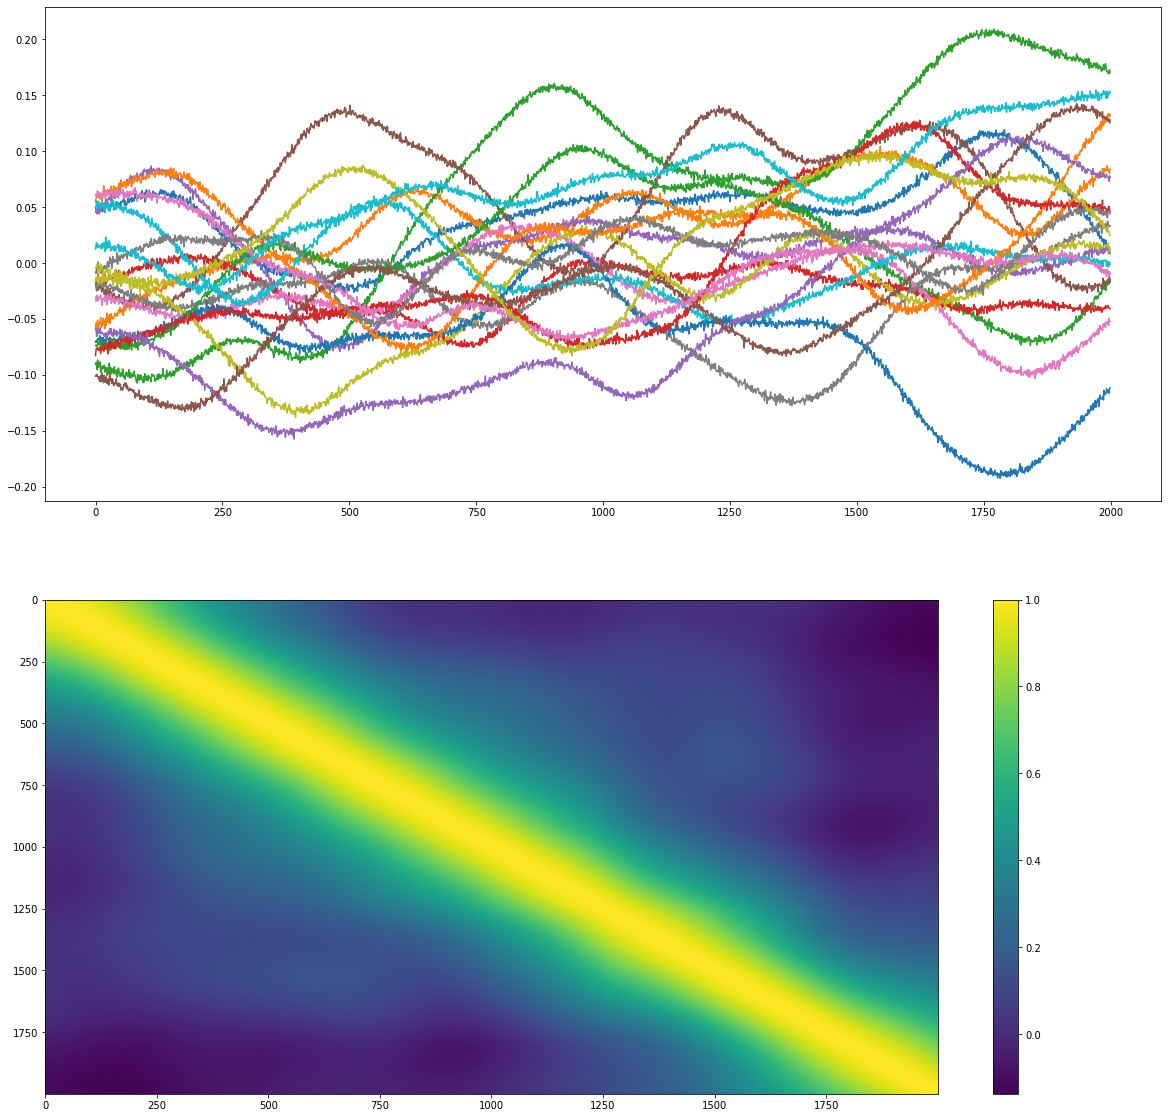

In [6]:
# create the positional encoder, with a resolution (max lag) of 1000
_, params = spe.SPE.init(jax.random.PRNGKey(0), 1, 1, dimension=1, resolution=1000)
encoder = functools.partial(spe.SPE.call, params, dimension=1, resolution=1000)
print(params)
print(params['msd'].shape)

# generate some encodings of length
p = encoder(num=256, shape=2000)

# display the first 20 of them
p = np.asarray(p)
plt.figure(figsize=[20,20])
plt.subplot(211)
plt.plot(p[:20].T);

# compute the p.T p to display the corresponding attention matrix
plt.subplot(212)
plt.imshow(p.T @ p, aspect='auto')
plt.colorbar()